In [1]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 28.1 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 8.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install yahooquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 4.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

from re import search
from yahooquery import Screener

In [4]:
def getRates(ticker_input ,period_input  ,interval_input ):
    print(ticker_input+" "+period_input+" "+interval_input )
    data = yf.download(tickers=ticker_input, period = period_input, interval = interval_input)
    return data["Close"]

In [5]:
def getPercChange(d):
    x=round(d.head(1),6).values
    y=round(d.tail(1),6).values
    perc_chg= np.round( (  (y-x) / abs(x)  ) *100  , 4)
    return perc_chg

In [6]:
def mail2me(pair_text,message_text):
    from email.message import EmailMessage
    import smtplib
    from pretty_html_table import build_table

    sender = "ozukun83@gmail.com"
    recipient = "ozukun83@gmail.com"
    message = "Crypto Info all"

    password = input("Type your password and press enter: ")
    
    email = EmailMessage()
    email["From"] = sender
    email["To"] = recipient
    email["Subject"] = "Crypto Rates Python!"+"  "+pair_text
    email.set_content(message_text)

    
    
    smtp = smtplib.SMTP_SSL("smtp.gmail.com")
    smtp.login(sender, password)
    smtp.sendmail(sender, recipient, email.as_string())
    smtp.quit()
    print("Mail succeed !!")

In [7]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=8)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [8]:
# moving average
def get_ma(prices, rate):
    return prices.rolling(rate).mean()



def get_bollinger_bands(prices, rate=7):
    sma = get_ma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down


def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    
    macd = pd.DataFrame(exp1 - exp2)
    macd.columns=["macd"]
    
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean())
    signal.columns=["signal"]
    
    hist = pd.DataFrame(macd['macd'] - signal['signal'])
    hist.columns=["hist"]
    
    frames =  [macd, signal, hist]
    
    df = pd.concat(frames, join = 'inner', axis = 1)
    df["result"]= np.select([df.macd > df.signal , df.macd < df.signal], ["Buy", "Sell"])
    return df




#HISTOGRAM = MACD LINE - SIGNAL LINE

#IF MACD LINE > SIGNAL LINE => BUY THE STOCK
#IF SIGNAL LINE > MACD LINE => SELL THE STOCK

#---------------------------------------------------------------


df_tmp_f = pd.DataFrame()
df_buy_signal=pd.DataFrame()
final_text=""
#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cpx in getCryptoPairs():
    Crypto_Pairs.append(cpx)


for cp in Crypto_Pairs:

    df_tmp_0 = pd.DataFrame(getRates(cp,  '1y',  '1d'))

    bollinger_up, bollinger_down = get_bollinger_bands(df_tmp_0)

    cp_macd=get_macd(getRates(cp,  '1y',  '1d'), 26, 12, 9)
    
    #display(cp_macd.iloc[-7:])

    df_tmp = pd.DataFrame(data=np.column_stack((df_tmp_0.values,bollinger_up,bollinger_down,cp_macd.macd,
                                                cp_macd.signal,cp_macd.result )),
                          columns=['Price','Bol_Up','Bol_Down',"macd","signal","result"])
    df_tmp.insert(0,'Crypto_Pair',cp)
    df_tmp.index=df_tmp_0.index


    #display( df_tmp.iloc[-7:] )
    
    x=round( df_tmp["Bol_Up"].iloc[-90:].mean() ,6 )
    #print("Bol_Up__Mean_for_last_7days   : " + str( x ) )
    
    
    y=round( df_tmp["Bol_Down"].iloc[-90:].mean() ,6 )
    #print("Bol_Down__Mean_for_last_7days : " + str( y ) )
    
    
    df_tmp_2 = pd.DataFrame(data=np.column_stack((cp,df_tmp.iloc[-1].Price,x,y )),
                          columns=["Crypto_Pair",'Price','Bol_Up_30','Bol_Down_30'])
    
    
    #display( df_tmp_2["Bol_Up_30"].values )
    
    x1="Bol_Up__Mean_for_last_7days   : " + str( x )
    y1="Bol_Down__Mean_for_last_7days : " + str( y )
    
    df_tmp_f = df_tmp_f.append(df_tmp.iloc[-7:])
    final_text=final_text+"\n"+cp+"\n"+str(x1)+"\n"+str(y1)
    r0=df_tmp.iloc[-1].Price
    r1= ( df_tmp.iloc[-1].Price+(df_tmp.iloc[-1].Price*0.05) ) 
    r2=float(df_tmp_2["Bol_Up_30"].values) 
    df_tmp_2["%change"]=((r2-r0)/ abs(r0) ) *100
    #print(r1)
    #print(r2)
    if r1<=r2:
        print("BUY_signal")
        df_buy_signal=df_buy_signal.append(df_tmp_2)
        #display(df_buy_signal)
        
#---------------------------------------------------------------------------
#display(df_buy_signal)
#mail2me_v2(df_buy_signal,"Crypto Bollinger bands",final_text)
#mail2me_v2(df_buy_signal,"Crypto Bollinger bands","")

BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BUY_signal
STETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
STETH-USD 1y 1d
[*********************100%***********************]  1 of 1

In [9]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=10)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [10]:
def getRatesTable(*args):
    df_table = pd.DataFrame()
    for cp in args:
        df10yr=getRates(cp, '10y',  '1d')
        df5yr=getRates(cp,  '5y',  '1d')
        df3yr=getRates(cp,  '3y',  '1d')
        df1yr=getRates(cp,  '1y',  '1d')
        df3mo=getRates(cp,  '3mo',  '1h')
        df1mo=getRates(cp,  '1mo',  '1h')
        df1wk=getRates(cp,  '1wk',  '1h')
        df1dy=getRates(cp,  '1dy',  '1h')
        new_row = pd.Series(data={
                                   'Crypto_Pair':cp,
                                   '10yr_d_CHG%':getPercChange(df10yr)[0],
                                   '5yr_d_CHG%':getPercChange(df5yr)[0],
                                   '3yr_d_CHG%':getPercChange(df3yr)[0],
                                   '1yr_d_CHG%':getPercChange(df1yr)[0], 
                                   '3mo_h_CHG%':getPercChange(df3mo)[0], 
                                   '1mo_h_CHG%':getPercChange(df1mo)[0] ,
                                   '1wk_h_CHG%':getPercChange(df1wk)[0],
                                   '1dy_h_CHG%':getPercChange(df1dy)[0], 
                                 } 
                           )
        
        df_table = df_table.append(new_row, ignore_index=True)
    return df_table

#--------------------------------------------------------------------


#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cp in getCryptoPairs():
    Crypto_Pairs.append(cp)

dfx=getRatesTable(*Crypto_Pairs)

#dfx

BTC-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 complete

In [11]:
display(dfx)

,Crypto_Pair,10yr_d_CHG%,5yr_d_CHG%,3yr_d_CHG%,1yr_d_CHG%,3mo_h_CHG%,1mo_h_CHG%,1wk_h_CHG%,1dy_h_CHG%
0,BTC-USD,5885.4251,182.2726,262.5181,-30.6464,19.4834,-0.0017,-7.1077,-0.1357
1,ETH-USD,471.1912,158.8209,868.5536,-37.2895,14.4477,4.8849,-11.7576,-1.1217
2,BNB-USD,16544.5438,2070.5397,1968.8433,-16.9757,7.7781,3.2226,-2.5836,-0.0996
3,XRP-USD,112.0857,-50.6557,138.1747,-33.9867,10.6073,9.1107,-9.8670,0.0046
4,ADA-USD,1093.7666,22.2974,813.9152,-56.8299,2.5421,6.4261,-11.8644,-1.7872
5,STETH-USD,211.9493,211.9493,211.9493,-37.0423,15.2807,4.9427,-11.4314,-0.9788
6,DOGE-USD,5435.9717,1250.5862,3624.8692,-40.6322,-9.5565,4.1703,-14.5786,-0.7677
7,HEX-USD,33688.8889,33688.8889,2625.4245,-56.0583,130.3329,-33.4458,-17.7582,-1.0040


In [12]:
def mail2me_v2(df,mail_subject,message_text):
    
    from email.mime.text import MIMEText
    from email.mime.application import MIMEApplication
    from email.mime.multipart import MIMEMultipart
    from smtplib import SMTP
    import smtplib
    import sys


    recipients = ['ozukun83@gmail.com'] 
    emaillist = [elem.strip().split(',') for elem in recipients]
    msg = MIMEMultipart()
    msg['Subject'] = mail_subject
    msg['From'] = 'ozukun83@gmail.com'

    password = input("Type your password and press enter: ")
    

    html = """\
    <html>
      <head></head>
      <body>
        {0}
      </body>
    </html>
    """.format(df.to_html())

    part1 = MIMEText(html, 'html')
    msg.attach(part1)
    body = message_text
    body = MIMEText(body) # convert the body to a MIME compatible string
    msg.attach(body)

    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.ehlo()
    server.login("ozukun83@gmail.com",password)
    server.sendmail(msg['From'], emaillist , msg.as_string())
    print("Mail succeed !!")
    
#---------------------------------------------------------------------------
#mail2me_v2(dfx,"Crypto Rate changes","")

ETH-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed


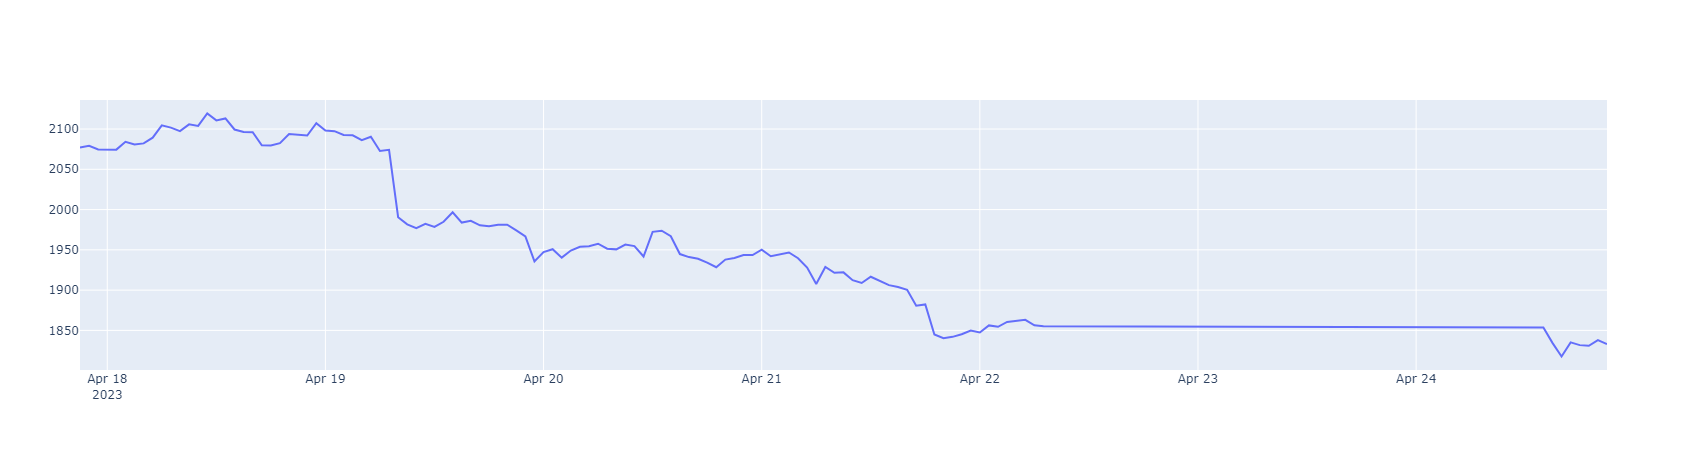

ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed


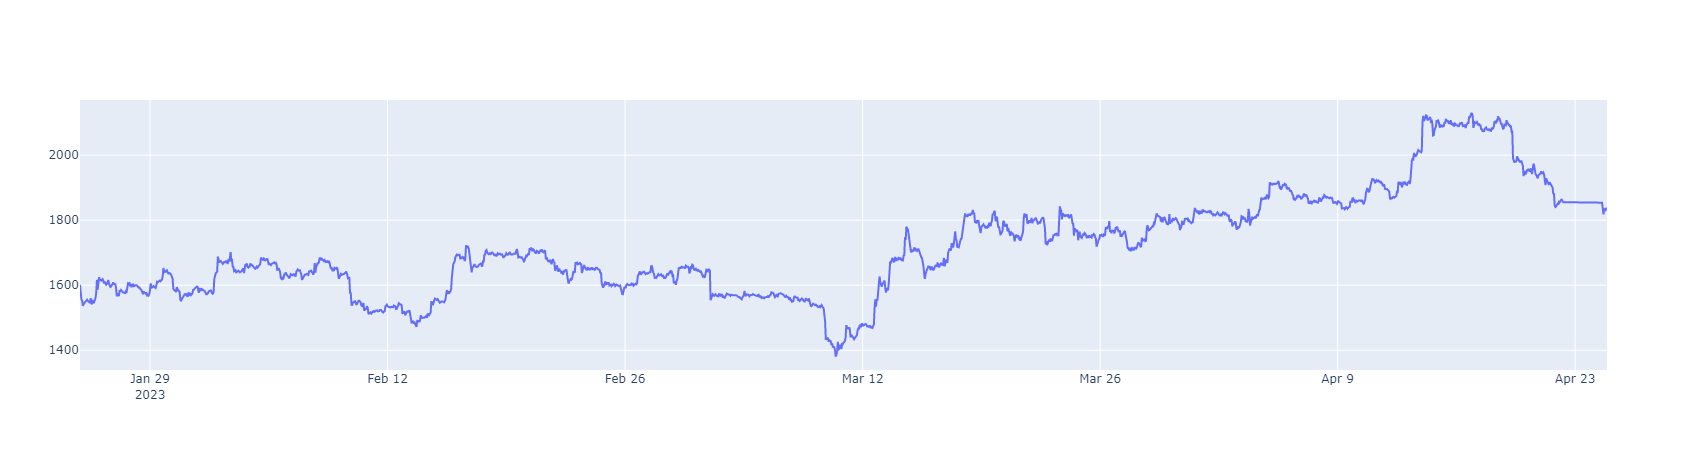

In [13]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def getLine(df_input):
    x = df_input.index
    y = df_input.values
    fig = go.Figure(data=go.Scatter(x = x, y = y))
    fig.show()
    
#------------------------------------------------

#( getLine(getRates('ETH-USD',  '1d',  '1h')) )
( getLine(getRates('ETH-USD',  '1wk',  '1h')) )
( getLine(getRates('ETH-USD',  '3mo',  '1h')) )
#( getLine(getRates('ETH-USD',  '3y',  '1d')) )

In [14]:
from datetime import timedelta
df_ALGO = pd.DataFrame(getRates('ALGO-USD',  '10y',  '1d'))
date=df_ALGO.index[-1]+ timedelta(days=1)

print(df_ALGO)

df_ALGO.loc[date, :] = [0]


print(df_ALGO.size)

df_ALGO['S1'] = df_ALGO['Close'].shift(1)
df_ALGO['SMA3'] = df_ALGO['Close'].rolling(3).mean().shift(1)
df_ALGO['SMA5'] = df_ALGO['Close'].rolling(5).mean().shift(1)
df_ALGO['SMA15'] = df_ALGO['Close'].rolling(15).mean().shift(1)
df_ALGO['SMA30'] = df_ALGO['Close'].rolling(30).mean().shift(1)

df_ALGO['S1'] = df_ALGO['S1'].fillna(0)
df_ALGO['SMA3'] = df_ALGO['SMA3'].fillna(0)
df_ALGO['SMA5'] = df_ALGO['SMA5'].fillna(0)
df_ALGO['SMA15'] = df_ALGO['SMA15'].fillna(0)
df_ALGO['SMA30'] = df_ALGO['SMA30'].fillna(0)



X = df_ALGO.iloc[:, 1:-1].values
y = df_ALGO.iloc[:, 0].values



df_ALGO

ALGO-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
               Close
Date                
2019-06-21  3.201412
2019-06-22  2.158967
2019-06-23  1.890702
2019-06-24  1.383728
2019-06-25  1.537290
...              ...
2023-04-20  0.190655
2023-04-21  0.185183
2023-04-22  0.190106
2023-04-23  0.187952
2023-04-24  0.185236

[1404 rows x 1 columns]
1405


,Close,S1,SMA3,SMA5,SMA15,SMA30
Date,,,,,,
2019-06-21,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-22,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000
2019-06-23,1.890702,2.158967,0.000000,0.000000,0.000000,0.000000
2019-06-24,1.383728,1.890702,2.417027,0.000000,0.000000,0.000000
2019-06-25,1.537290,1.383728,1.811132,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
2023-04-21,0.185183,0.190655,0.204067,0.213550,0.218337,0.217122
2023-04-22,0.190106,0.185183,0.191674,0.203615,0.216165,0.216159
2023-04-23,0.187952,0.190106,0.188648,0.197498,0.214217,0.215173


In [15]:
# RNN Implementation FOR ALGO-USD pair

df_RNN = pd.DataFrame(columns=['Pair','p_units' ,'p_epoch' ,'p_batch_size' ,'prediction'])


df_alg = pd.DataFrame(getRates('ALGO-USD',  '10y',  '1d'))
date=df_alg.index[-1]+ timedelta(days=1)
df_alg.loc[date, :] = [0]


for i in range (1,91):
    a="Close_"+str(i)
    #print(a)
    df_alg[a]=df_alg['Close'].shift(i)

df_alg=df_alg.fillna(0)
display(df_alg)


X = df_alg.iloc[:, 1:].values
y = df_alg.iloc[:, 0].values

print(y.shape)
print(y)
y=y.reshape(-1,1)
print(y)

def calc_LTSM( *param_list ):
    for param in param_list:
        p_units=param[0] 
        p_epoch=param[1]  
        p_batch_size=param[2] 

        #from numpy.random import seed
        import tensorflow 
        #seed(0)
        tensorflow.random.set_seed(0)
        
        # Feature Scaling
        from sklearn.preprocessing import MinMaxScaler
        sc = MinMaxScaler(feature_range = (0, 1))
        X_scaled = sc.fit_transform(X)
        y_scaled = sc.fit_transform(y)

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size = 0.1, shuffle=False)
        # Reshaping
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

        # Importing the Keras libraries and packages
        from keras.models import Sequential
        from keras.layers import Dense
        from keras.layers import LSTM
        from keras.layers import Dropout
        regressor = Sequential()

        # Adding the first LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = p_units, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        regressor.add(Dropout(0.2))

        # Adding a second LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = p_units, return_sequences = True))
        regressor.add(Dropout(0.2))

        # Adding a fourth LSTM layer and some Dropout regularisation
        regressor.add(LSTM(units = p_units))
        regressor.add(Dropout(0.2))

        # Adding the output layer
        regressor.add(Dense(units = 1))

        # Compiling the RNN
        regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
        # Fitting the RNN to the Training set
        regressor.fit(X_train, y_train, epochs = p_epoch, batch_size = p_batch_size)

        lastElementIndex = len(X_test)-1
        # Removing the last element using slicing 
        X_pre = X_test[:lastElementIndex]
        y_pre = y_test[:lastElementIndex]
        X_pre = np.array(X_pre)
        X_pre = np.reshape(X_pre, (X_pre.shape[0], X_pre.shape[1], 1)) #   lenght of dataset,lenght of time_series , nof_input
        predicted_stock_price = regressor.predict(X_pre)
        #print("*****")
        #print(predicted_stock_price)

        index1 = len(X_test)-1
        index2 = len(X_test)
        X_final = X_test[index1:index2]
        y_final = y_test[index1:index2]
        X_final = np.array(X_final)
        X_final = np.reshape(X_final, (X_final.shape[0], X_final.shape[1], 1))

        print(y_final)
        print("Params: "+str(p_units)+" "+str(p_epoch)+" "+str(p_batch_size) )
        predicted_stock_price = regressor.predict(X_final)
        predicted_stock_price_f = sc.inverse_transform(predicted_stock_price)

        row1 = pd.Series(["ALGO-USD",p_units ,p_epoch ,p_batch_size,predicted_stock_price_f] ,index=df_RNN.columns )
        print(row1)
        df_RNN.loc[len(df_RNN.index)] = row1
        display(df_RNN)
        return predicted_stock_price_f







ALGO-USD 10y 1d
[*********************100%***********************]  1 of 1 completed


,Close,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Close_8,Close_9,...,Close_81,Close_82,Close_83,Close_84,Close_85,Close_86,Close_87,Close_88,Close_89,Close_90
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-21,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-22,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-23,1.890702,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-24,1.383728,1.890702,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-25,1.537290,1.383728,1.890702,2.158967,3.201412,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-21,0.185183,0.190655,0.199185,0.222360,0.220693,0.234859,0.232241,0.227652,0.221626,0.214905,...,0.239771,0.262193,0.257302,0.254728,0.245808,0.245368,0.237040,0.250303,0.246711,0.239667
2023-04-22,0.190106,0.185183,0.190655,0.199185,0.222360,0.220693,0.234859,0.232241,0.227652,0.221626,...,0.242206,0.239771,0.262193,0.257302,0.254728,0.245808,0.245368,0.237040,0.250303,0.246711
2023-04-23,0.187952,0.190106,0.185183,0.190655,0.199185,0.222360,0.220693,0.234859,0.232241,0.227652,...,0.251032,0.242206,0.239771,0.262193,0.257302,0.254728,0.245808,0.245368,0.237040,0.250303


(1405,)
[3.20141196 2.15896702 1.89070201 ... 0.187952   0.18523638 0.        ]
[[3.20141196]
 [2.15896702]
 [1.89070201]
 ...
 [0.187952  ]
 [0.18523638]
 [0.        ]]


In [16]:
param_list=[]
for z in range (10,150,10):
    #print(z)
    param_list.append([z,10,150])
display(param_list)


for k in param_list:
    calc_LTSM(k)



display(df_RNN)
print(df_RNN.prediction.mean)

[[10, 10, 150],
 [20, 10, 150],
 [30, 10, 150],
 [40, 10, 150],
 [50, 10, 150],
 [60, 10, 150],
 [70, 10, 150],
 [80, 10, 150],
 [90, 10, 150],
 [100, 10, 150],
 [110, 10, 150],
 [120, 10, 150],
 [130, 10, 150],
 [140, 10, 150]]

Epoch 1/10
9/9 [==============================] - 5s 68ms/step - loss: 0.0452
Epoch 2/10
9/9 [==============================] - 1s 66ms/step - loss: 0.0252
Epoch 3/10
9/9 [==============================] - 1s 67ms/step - loss: 0.0221
Epoch 4/10
9/9 [==============================] - 1s 64ms/step - loss: 0.0218
Epoch 5/10
9/9 [==============================] - 1s 65ms/step - loss: 0.0208
Epoch 6/10
9/9 [==============================] - 1s 65ms/step - loss: 0.0214
Epoch 7/10
9/9 [==============================] - 1s 63ms/step - loss: 0.0212
Epoch 8/10
9/9 [==============================] - 1s 66ms/step - loss: 0.0198
Epoch 9/10
9/9 [==============================] - 1s 65ms/step - loss: 0.0205
Epoch 10/10
9/9 [==============================] - 1s 65ms/step - loss: 0.0198
[[0.]]
Params: 10 10 150
Pair                  ALGO-USD
p_units                     10
p_epoch                     10
p_batch_size               150
prediction      [[0.43503857]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]


Epoch 1/10
9/9 [==============================] - 6s 168ms/step - loss: 0.0317
Epoch 2/10
9/9 [==============================] - 2s 168ms/step - loss: 0.0217
Epoch 3/10
9/9 [==============================] - 2s 168ms/step - loss: 0.0206
Epoch 4/10
9/9 [==============================] - 2s 175ms/step - loss: 0.0200
Epoch 5/10
9/9 [==============================] - 2s 166ms/step - loss: 0.0195
Epoch 6/10
9/9 [==============================] - 2s 169ms/step - loss: 0.0193
Epoch 7/10
9/9 [==============================] - 2s 168ms/step - loss: 0.0186
Epoch 8/10
9/9 [==============================] - 1s 164ms/step - loss: 0.0190
Epoch 9/10
9/9 [==============================] - 2s 166ms/step - loss: 0.0187
Epoch 10/10
9/9 [==============================] - 2s 167ms/step - loss: 0.0185
[[0.]]
Params: 20 10 150
Pair                 ALGO-USD
p_units                    20
p_epoch                    10
p_batch_size              150
prediction      [[0.4431275]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]


Epoch 1/10
9/9 [==============================] - 6s 223ms/step - loss: 0.0372
Epoch 2/10
9/9 [==============================] - 2s 183ms/step - loss: 0.0225
Epoch 3/10
9/9 [==============================] - 2s 186ms/step - loss: 0.0206
Epoch 4/10
9/9 [==============================] - 2s 190ms/step - loss: 0.0198
Epoch 5/10
9/9 [==============================] - 2s 185ms/step - loss: 0.0192
Epoch 6/10
9/9 [==============================] - 2s 182ms/step - loss: 0.0190
Epoch 7/10
9/9 [==============================] - 2s 184ms/step - loss: 0.0190
Epoch 8/10
9/9 [==============================] - 2s 185ms/step - loss: 0.0186
Epoch 9/10
9/9 [==============================] - 2s 183ms/step - loss: 0.0184
Epoch 10/10
9/9 [==============================] - 2s 185ms/step - loss: 0.0177
[[0.]]
Params: 30 10 150
Pair                 ALGO-USD
p_units                    30
p_epoch                    10
p_batch_size              150
prediction      [[0.4229574]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]


Epoch 1/10
9/9 [==============================] - 6s 200ms/step - loss: 0.0362
Epoch 2/10
9/9 [==============================] - 2s 202ms/step - loss: 0.0211
Epoch 3/10
9/9 [==============================] - 2s 209ms/step - loss: 0.0202
Epoch 4/10
9/9 [==============================] - 2s 201ms/step - loss: 0.0194
Epoch 5/10
9/9 [==============================] - 2s 238ms/step - loss: 0.0184
Epoch 6/10
9/9 [==============================] - 2s 201ms/step - loss: 0.0191
Epoch 7/10
9/9 [==============================] - 2s 202ms/step - loss: 0.0189
Epoch 8/10
9/9 [==============================] - 2s 203ms/step - loss: 0.0181
Epoch 9/10
9/9 [==============================] - 2s 206ms/step - loss: 0.0170
Epoch 10/10
9/9 [==============================] - 2s 203ms/step - loss: 0.0139
[[0.]]
Params: 40 10 150
Pair                 ALGO-USD
p_units                    40
p_epoch                    10
p_batch_size              150
prediction      [[0.2458778]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]


Epoch 1/10
9/9 [==============================] - 6s 218ms/step - loss: 0.0375
Epoch 2/10
9/9 [==============================] - 2s 221ms/step - loss: 0.0211
Epoch 3/10
9/9 [==============================] - 2s 226ms/step - loss: 0.0198
Epoch 4/10
9/9 [==============================] - 2s 223ms/step - loss: 0.0190
Epoch 5/10
9/9 [==============================] - 2s 218ms/step - loss: 0.0187
Epoch 6/10
9/9 [==============================] - 2s 223ms/step - loss: 0.0185
Epoch 7/10
9/9 [==============================] - 2s 225ms/step - loss: 0.0179
Epoch 8/10
9/9 [==============================] - 2s 284ms/step - loss: 0.0166
Epoch 9/10
9/9 [==============================] - 2s 228ms/step - loss: 0.0124
Epoch 10/10
9/9 [==============================] - 2s 224ms/step - loss: 0.0106
[[0.]]
Params: 50 10 150
Pair                 ALGO-USD
p_units                    50
p_epoch                    10
p_batch_size              150
prediction      [[0.1763475]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]


Epoch 1/10
9/9 [==============================] - 7s 244ms/step - loss: 0.0306
Epoch 2/10
9/9 [==============================] - 2s 242ms/step - loss: 0.0203
Epoch 3/10
9/9 [==============================] - 2s 243ms/step - loss: 0.0191
Epoch 4/10
9/9 [==============================] - 2s 248ms/step - loss: 0.0189
Epoch 5/10
9/9 [==============================] - 2s 244ms/step - loss: 0.0181
Epoch 6/10
9/9 [==============================] - 2s 247ms/step - loss: 0.0180
Epoch 7/10
9/9 [==============================] - 2s 245ms/step - loss: 0.0167
Epoch 8/10
9/9 [==============================] - 2s 245ms/step - loss: 0.0139
Epoch 9/10
9/9 [==============================] - 3s 307ms/step - loss: 0.0136
Epoch 10/10
9/9 [==============================] - 2s 254ms/step - loss: 0.0093
[[0.]]
Params: 60 10 150
Pair                  ALGO-USD
p_units                     60
p_epoch                     10
p_batch_size               150
prediction      [[0.28465793]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]


Epoch 1/10
9/9 [==============================] - 7s 281ms/step - loss: 0.0300
Epoch 2/10
9/9 [==============================] - 2s 269ms/step - loss: 0.0202
Epoch 3/10
9/9 [==============================] - 2s 268ms/step - loss: 0.0192
Epoch 4/10
9/9 [==============================] - 2s 269ms/step - loss: 0.0188
Epoch 5/10
9/9 [==============================] - 2s 274ms/step - loss: 0.0185
Epoch 6/10
9/9 [==============================] - 2s 276ms/step - loss: 0.0174
Epoch 7/10
9/9 [==============================] - 2s 275ms/step - loss: 0.0141
Epoch 8/10
9/9 [==============================] - 2s 267ms/step - loss: 0.0125
Epoch 9/10
9/9 [==============================] - 3s 326ms/step - loss: 0.0098
Epoch 10/10
9/9 [==============================] - 3s 283ms/step - loss: 0.0075
[[0.]]
Params: 70 10 150
Pair                 ALGO-USD
p_units                    70
p_epoch                    10
p_batch_size              150
prediction      [[0.2579157]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]


Epoch 1/10
9/9 [==============================] - 7s 298ms/step - loss: 0.0285
Epoch 2/10
9/9 [==============================] - 3s 294ms/step - loss: 0.0194
Epoch 3/10
9/9 [==============================] - 3s 286ms/step - loss: 0.0190
Epoch 4/10
9/9 [==============================] - 3s 281ms/step - loss: 0.0180
Epoch 5/10
9/9 [==============================] - 3s 288ms/step - loss: 0.0174
Epoch 6/10
9/9 [==============================] - 3s 289ms/step - loss: 0.0145
Epoch 7/10
9/9 [==============================] - 3s 286ms/step - loss: 0.0151
Epoch 8/10
9/9 [==============================] - 3s 345ms/step - loss: 0.0133
Epoch 9/10
9/9 [==============================] - 3s 283ms/step - loss: 0.0106
Epoch 10/10
9/9 [==============================] - 3s 291ms/step - loss: 0.0078
[[0.]]
Params: 80 10 150
Pair                 ALGO-USD
p_units                    80
p_epoch                    10
p_batch_size              150
prediction      [[0.1854017]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]


Epoch 1/10
9/9 [==============================] - 8s 343ms/step - loss: 0.0303
Epoch 2/10
9/9 [==============================] - 3s 332ms/step - loss: 0.0200
Epoch 3/10
9/9 [==============================] - 3s 342ms/step - loss: 0.0191
Epoch 4/10
9/9 [==============================] - 3s 340ms/step - loss: 0.0187
Epoch 5/10
9/9 [==============================] - 3s 345ms/step - loss: 0.0183
Epoch 6/10
9/9 [==============================] - 4s 408ms/step - loss: 0.0166
Epoch 7/10
9/9 [==============================] - 3s 340ms/step - loss: 0.0154
Epoch 8/10
9/9 [==============================] - 3s 351ms/step - loss: 0.0111
Epoch 9/10
9/9 [==============================] - 3s 338ms/step - loss: 0.0095
Epoch 10/10
9/9 [==============================] - 3s 334ms/step - loss: 0.0081
[[0.]]
Params: 90 10 150
Pair                  ALGO-USD
p_units                     90
p_epoch                     10
p_batch_size               150
prediction      [[0.17921911]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]


Epoch 1/10
9/9 [==============================] - 8s 362ms/step - loss: 0.0299
Epoch 2/10
9/9 [==============================] - 3s 361ms/step - loss: 0.0198
Epoch 3/10
9/9 [==============================] - 3s 372ms/step - loss: 0.0191
Epoch 4/10
9/9 [==============================] - 4s 420ms/step - loss: 0.0187
Epoch 5/10
9/9 [==============================] - 3s 367ms/step - loss: 0.0181
Epoch 6/10
9/9 [==============================] - 3s 367ms/step - loss: 0.0166
Epoch 7/10
9/9 [==============================] - 3s 357ms/step - loss: 0.0132
Epoch 8/10
9/9 [==============================] - 3s 366ms/step - loss: 0.0205
Epoch 9/10
9/9 [==============================] - 3s 356ms/step - loss: 0.0128
Epoch 10/10
9/9 [==============================] - 3s 368ms/step - loss: 0.0103
[[0.]]
Params: 100 10 150
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size               150
prediction      [[0.26254755]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


Epoch 1/10
9/9 [==============================] - 9s 484ms/step - loss: 0.0292
Epoch 2/10
9/9 [==============================] - 4s 424ms/step - loss: 0.0195
Epoch 3/10
9/9 [==============================] - 4s 415ms/step - loss: 0.0193
Epoch 4/10
9/9 [==============================] - 4s 416ms/step - loss: 0.0187
Epoch 5/10
9/9 [==============================] - 4s 410ms/step - loss: 0.0181
Epoch 6/10
9/9 [==============================] - 4s 418ms/step - loss: 0.0167
Epoch 7/10
9/9 [==============================] - 4s 403ms/step - loss: 0.0124
Epoch 8/10
9/9 [==============================] - 4s 419ms/step - loss: 0.0129
Epoch 9/10
9/9 [==============================] - 4s 468ms/step - loss: 0.0112
Epoch 10/10
9/9 [==============================] - 4s 406ms/step - loss: 0.0092
[[0.]]
Params: 110 10 150
Pair                 ALGO-USD
p_units                   110
p_epoch                    10
p_batch_size              150
prediction      [[0.2071057]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


Epoch 1/10
9/9 [==============================] - 8s 432ms/step - loss: 0.0316
Epoch 2/10
9/9 [==============================] - 4s 431ms/step - loss: 0.0207
Epoch 3/10
9/9 [==============================] - 4s 437ms/step - loss: 0.0192
Epoch 4/10
9/9 [==============================] - 4s 438ms/step - loss: 0.0189
Epoch 5/10
9/9 [==============================] - 4s 427ms/step - loss: 0.0187
Epoch 6/10
9/9 [==============================] - 5s 445ms/step - loss: 0.0180
Epoch 7/10
9/9 [==============================] - 4s 434ms/step - loss: 0.0176
Epoch 8/10
9/9 [==============================] - 4s 429ms/step - loss: 0.0156
Epoch 9/10
9/9 [==============================] - 4s 432ms/step - loss: 0.0112
Epoch 10/10
9/9 [==============================] - 4s 436ms/step - loss: 0.0104
[[0.]]
Params: 120 10 150
Pair                 ALGO-USD
p_units                   120
p_epoch                    10
p_batch_size              150
prediction      [[0.4452435]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


Epoch 1/10
9/9 [==============================] - 10s 566ms/step - loss: 0.0285
Epoch 2/10
9/9 [==============================] - 5s 514ms/step - loss: 0.0195
Epoch 3/10
9/9 [==============================] - 5s 509ms/step - loss: 0.0190
Epoch 4/10
9/9 [==============================] - 5s 511ms/step - loss: 0.0181
Epoch 5/10
9/9 [==============================] - 5s 510ms/step - loss: 0.0174
Epoch 6/10
9/9 [==============================] - 5s 527ms/step - loss: 0.0156
Epoch 7/10
9/9 [==============================] - 5s 512ms/step - loss: 0.0114
Epoch 8/10
9/9 [==============================] - 5s 575ms/step - loss: 0.0078
Epoch 9/10
9/9 [==============================] - 5s 506ms/step - loss: 0.0073
Epoch 10/10
9/9 [==============================] - 5s 509ms/step - loss: 0.0074
[[0.]]
Params: 130 10 150
Pair                  ALGO-USD
p_units                    130
p_epoch                     10
p_batch_size               150
prediction      [[0.27004793]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


Epoch 1/10
9/9 [==============================] - 10s 554ms/step - loss: 0.0347
Epoch 2/10
9/9 [==============================] - 5s 528ms/step - loss: 0.0217
Epoch 3/10
9/9 [==============================] - 6s 625ms/step - loss: 0.0201
Epoch 4/10
9/9 [==============================] - 5s 548ms/step - loss: 0.0193
Epoch 5/10
9/9 [==============================] - 5s 542ms/step - loss: 0.0186
Epoch 6/10
9/9 [==============================] - 5s 541ms/step - loss: 0.0184
Epoch 7/10
9/9 [==============================] - 5s 568ms/step - loss: 0.0175
Epoch 8/10
9/9 [==============================] - 5s 526ms/step - loss: 0.0140
Epoch 9/10
9/9 [==============================] - 5s 616ms/step - loss: 0.0138
Epoch 10/10
9/9 [==============================] - 5s 546ms/step - loss: 0.0097
[[0.]]
Params: 140 10 150
Pair                  ALGO-USD
p_units                    140
p_epoch                     10
p_batch_size               150
prediction      [[0.28490895]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


<bound method NDFrame._add_numeric_operations.<locals>.mean of 0     [[0.43503857]]
1      [[0.4431275]]
2      [[0.4229574]]
3      [[0.2458778]]
4      [[0.1763475]]
5     [[0.28465793]]
6      [[0.2579157]]
7      [[0.1854017]]
8     [[0.17921911]]
9     [[0.26254755]]
10     [[0.2071057]]
11     [[0.4452435]]
12    [[0.27004793]]
13    [[0.28490895]]
Name: prediction, dtype: object>


In [17]:
param_list=[]
for z in range (50,5000,100):
    #print(z)
    param_list.append([100,10,z])
display(param_list)


for k in param_list:
    print(k)
    calc_LTSM(k)



display(df_RNN)
print(df_RNN.prediction.mean)

[[100, 10, 50],
 [100, 10, 150],
 [100, 10, 250],
 [100, 10, 350],
 [100, 10, 450],
 [100, 10, 550],
 [100, 10, 650],
 [100, 10, 750],
 [100, 10, 850],
 [100, 10, 950],
 [100, 10, 1050],
 [100, 10, 1150],
 [100, 10, 1250],
 [100, 10, 1350],
 [100, 10, 1450],
 [100, 10, 1550],
 [100, 10, 1650],
 [100, 10, 1750],
 [100, 10, 1850],
 [100, 10, 1950],
 [100, 10, 2050],
 [100, 10, 2150],
 [100, 10, 2250],
 [100, 10, 2350],
 [100, 10, 2450],
 [100, 10, 2550],
 [100, 10, 2650],
 [100, 10, 2750],
 [100, 10, 2850],
 [100, 10, 2950],
 [100, 10, 3050],
 [100, 10, 3150],
 [100, 10, 3250],
 [100, 10, 3350],
 [100, 10, 3450],
 [100, 10, 3550],
 [100, 10, 3650],
 [100, 10, 3750],
 [100, 10, 3850],
 [100, 10, 3950],
 [100, 10, 4050],
 [100, 10, 4150],
 [100, 10, 4250],
 [100, 10, 4350],
 [100, 10, 4450],
 [100, 10, 4550],
 [100, 10, 4650],
 [100, 10, 4750],
 [100, 10, 4850],
 [100, 10, 4950]]

[100, 10, 50]
Epoch 1/10
26/26 [==============================] - 10s 223ms/step - loss: 0.0225
Epoch 2/10
26/26 [==============================] - 6s 224ms/step - loss: 0.0182
Epoch 3/10
26/26 [==============================] - 6s 222ms/step - loss: 0.0166
Epoch 4/10
26/26 [==============================] - 6s 223ms/step - loss: 0.0138
Epoch 5/10
26/26 [==============================] - 6s 218ms/step - loss: 0.0091
Epoch 6/10
26/26 [==============================] - 6s 219ms/step - loss: 0.0086
Epoch 7/10
26/26 [==============================] - 6s 220ms/step - loss: 0.0075
Epoch 8/10
26/26 [==============================] - 6s 222ms/step - loss: 0.0070
Epoch 9/10
26/26 [==============================] - 6s 239ms/step - loss: 0.0069
Epoch 10/10
26/26 [==============================] - 6s 221ms/step - loss: 0.0073
[[0.]]
Params: 100 10 50
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size                50
prediction      [[0.40422

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 150]
Epoch 1/10
9/9 [==============================] - 8s 372ms/step - loss: 0.0299
Epoch 2/10
9/9 [==============================] - 3s 364ms/step - loss: 0.0198
Epoch 3/10
9/9 [==============================] - 3s 380ms/step - loss: 0.0191
Epoch 4/10
9/9 [==============================] - 3s 379ms/step - loss: 0.0187
Epoch 5/10
9/9 [==============================] - 4s 435ms/step - loss: 0.0181
Epoch 6/10
9/9 [==============================] - 3s 388ms/step - loss: 0.0166
Epoch 7/10
9/9 [==============================] - 3s 369ms/step - loss: 0.0132
Epoch 8/10
9/9 [==============================] - 3s 372ms/step - loss: 0.0205
Epoch 9/10
9/9 [==============================] - 3s 372ms/step - loss: 0.0128
Epoch 10/10
9/9 [==============================] - 4s 392ms/step - loss: 0.0103
[[0.]]
Params: 100 10 150
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size               150
prediction      [[0.26254755]]
dtype: object

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 250]
Epoch 1/10
6/6 [==============================] - 7s 500ms/step - loss: 0.0341
Epoch 2/10
6/6 [==============================] - 3s 573ms/step - loss: 0.0198
Epoch 3/10
6/6 [==============================] - 3s 473ms/step - loss: 0.0191
Epoch 4/10
6/6 [==============================] - 3s 484ms/step - loss: 0.0189
Epoch 5/10
6/6 [==============================] - 3s 477ms/step - loss: 0.0185
Epoch 6/10
6/6 [==============================] - 3s 483ms/step - loss: 0.0182
Epoch 7/10
6/6 [==============================] - 3s 474ms/step - loss: 0.0197
Epoch 8/10
6/6 [==============================] - 3s 494ms/step - loss: 0.0186
Epoch 9/10
6/6 [==============================] - 3s 478ms/step - loss: 0.0176
Epoch 10/10
6/6 [==============================] - 3s 484ms/step - loss: 0.0158
[[0.]]
Params: 100 10 250
Pair                 ALGO-USD
p_units                   100
p_epoch                    10
p_batch_size              250
prediction      [[0.2585341]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 350]
Epoch 1/10
4/4 [==============================] - 7s 685ms/step - loss: 0.0392
Epoch 2/10
4/4 [==============================] - 3s 691ms/step - loss: 0.0219
Epoch 3/10
4/4 [==============================] - 3s 686ms/step - loss: 0.0226
Epoch 4/10
4/4 [==============================] - 3s 686ms/step - loss: 0.0192
Epoch 5/10
4/4 [==============================] - 3s 684ms/step - loss: 0.0194
Epoch 6/10
4/4 [==============================] - 3s 697ms/step - loss: 0.0194
Epoch 7/10
4/4 [==============================] - 3s 670ms/step - loss: 0.0190
Epoch 8/10
4/4 [==============================] - 3s 648ms/step - loss: 0.0187
Epoch 9/10
4/4 [==============================] - 3s 671ms/step - loss: 0.0185
Epoch 10/10
4/4 [==============================] - 3s 666ms/step - loss: 0.0184
[[0.]]
Params: 100 10 350
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size               350
prediction      [[0.40738454]]
dtype: object

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 450]
Epoch 1/10
3/3 [==============================] - 7s 796ms/step - loss: 0.0416
Epoch 2/10
3/3 [==============================] - 2s 811ms/step - loss: 0.0275
Epoch 3/10
3/3 [==============================] - 2s 798ms/step - loss: 0.0223
Epoch 4/10
3/3 [==============================] - 2s 777ms/step - loss: 0.0218
Epoch 5/10
3/3 [==============================] - 3s 810ms/step - loss: 0.0193
Epoch 6/10
3/3 [==============================] - 2s 781ms/step - loss: 0.0201
Epoch 7/10
3/3 [==============================] - 2s 784ms/step - loss: 0.0190
Epoch 8/10
3/3 [==============================] - 3s 851ms/step - loss: 0.0195
Epoch 9/10
3/3 [==============================] - 3s 819ms/step - loss: 0.0192
Epoch 10/10
3/3 [==============================] - 2s 792ms/step - loss: 0.0189
[[0.]]
Params: 100 10 450
Pair                 ALGO-USD
p_units                   100
p_epoch                    10
p_batch_size              450
prediction      [[0.5083991]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 550]
Epoch 1/10
3/3 [==============================] - 7s 738ms/step - loss: 0.0473
Epoch 2/10
3/3 [==============================] - 3s 729ms/step - loss: 0.0279
Epoch 3/10
3/3 [==============================] - 3s 726ms/step - loss: 0.0229
Epoch 4/10
3/3 [==============================] - 3s 783ms/step - loss: 0.0228
Epoch 5/10
3/3 [==============================] - 2s 716ms/step - loss: 0.0196
Epoch 6/10
3/3 [==============================] - 3s 743ms/step - loss: 0.0207
Epoch 7/10
3/3 [==============================] - 2s 715ms/step - loss: 0.0190
Epoch 8/10
3/3 [==============================] - 3s 792ms/step - loss: 0.0197
Epoch 9/10
3/3 [==============================] - 2s 724ms/step - loss: 0.0190
Epoch 10/10
3/3 [==============================] - 3s 762ms/step - loss: 0.0189
[[0.]]
Params: 100 10 550
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size               550
prediction      [[0.51389915]]
dtype: object

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 650]
Epoch 1/10
2/2 [==============================] - 7s 1s/step - loss: 0.0516
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 0.0271
Epoch 3/10
2/2 [==============================] - 2s 1s/step - loss: 0.0218
Epoch 4/10
2/2 [==============================] - 2s 1s/step - loss: 0.0215
Epoch 5/10
2/2 [==============================] - 2s 1s/step - loss: 0.0229
Epoch 6/10
2/2 [==============================] - 2s 1s/step - loss: 0.0207
Epoch 7/10
2/2 [==============================] - 2s 1s/step - loss: 0.0188
Epoch 8/10
2/2 [==============================] - 2s 1s/step - loss: 0.0201
Epoch 9/10
2/2 [==============================] - 2s 1s/step - loss: 0.0197
Epoch 10/10
2/2 [==============================] - 2s 1s/step - loss: 0.0190
[[0.]]
Params: 100 10 650
Pair                 ALGO-USD
p_units                   100
p_epoch                    10
p_batch_size              650
prediction      [[0.4640294]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 750]
Epoch 1/10
2/2 [==============================] - 7s 996ms/step - loss: 0.0540
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 0.0255
Epoch 3/10
2/2 [==============================] - 2s 1s/step - loss: 0.0219
Epoch 4/10
2/2 [==============================] - 2s 1s/step - loss: 0.0212
Epoch 5/10
2/2 [==============================] - 2s 1s/step - loss: 0.0232
Epoch 6/10
2/2 [==============================] - 3s 1s/step - loss: 0.0206
Epoch 7/10
2/2 [==============================] - 2s 1s/step - loss: 0.0189
Epoch 8/10
2/2 [==============================] - 2s 1s/step - loss: 0.0201
Epoch 9/10
2/2 [==============================] - 2s 1s/step - loss: 0.0199
Epoch 10/10
2/2 [==============================] - 2s 1s/step - loss: 0.0191
[[0.]]
Params: 100 10 750
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size               750
prediction      [[0.46573102]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 850]
Epoch 1/10
2/2 [==============================] - 7s 867ms/step - loss: 0.0561
Epoch 2/10
2/2 [==============================] - 2s 924ms/step - loss: 0.0242
Epoch 3/10
2/2 [==============================] - 2s 925ms/step - loss: 0.0225
Epoch 4/10
2/2 [==============================] - 2s 883ms/step - loss: 0.0208
Epoch 5/10
2/2 [==============================] - 2s 870ms/step - loss: 0.0234
Epoch 6/10
2/2 [==============================] - 2s 875ms/step - loss: 0.0207
Epoch 7/10
2/2 [==============================] - 2s 854ms/step - loss: 0.0187
Epoch 8/10
2/2 [==============================] - 2s 855ms/step - loss: 0.0203
Epoch 9/10
2/2 [==============================] - 2s 834ms/step - loss: 0.0199
Epoch 10/10
2/2 [==============================] - 2s 839ms/step - loss: 0.0190
[[0.]]
Params: 100 10 850
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size               850
prediction      [[0.46806696]]
dtype: object

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 950]
Epoch 1/10
2/2 [==============================] - 7s 646ms/step - loss: 0.0586
Epoch 2/10
2/2 [==============================] - 2s 665ms/step - loss: 0.0231
Epoch 3/10
2/2 [==============================] - 2s 709ms/step - loss: 0.0232
Epoch 4/10
2/2 [==============================] - 2s 670ms/step - loss: 0.0211
Epoch 5/10
2/2 [==============================] - 2s 663ms/step - loss: 0.0237
Epoch 6/10
2/2 [==============================] - 2s 709ms/step - loss: 0.0209
Epoch 7/10
2/2 [==============================] - 2s 649ms/step - loss: 0.0187
Epoch 8/10
2/2 [==============================] - 2s 660ms/step - loss: 0.0205
Epoch 9/10
2/2 [==============================] - 2s 655ms/step - loss: 0.0198
Epoch 10/10
2/2 [==============================] - 2s 665ms/step - loss: 0.0189
[[0.]]
Params: 100 10 950
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size               950
prediction      [[0.45627466]]
dtype: object

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 1050]
Epoch 1/10
2/2 [==============================] - 7s 491ms/step - loss: 0.0615
Epoch 2/10
2/2 [==============================] - 2s 496ms/step - loss: 0.0217
Epoch 3/10
2/2 [==============================] - 2s 541ms/step - loss: 0.0231
Epoch 4/10
2/2 [==============================] - 2s 484ms/step - loss: 0.0209
Epoch 5/10
2/2 [==============================] - 2s 497ms/step - loss: 0.0236
Epoch 6/10
2/2 [==============================] - 2s 491ms/step - loss: 0.0213
Epoch 7/10
2/2 [==============================] - 2s 492ms/step - loss: 0.0188
Epoch 8/10
2/2 [==============================] - 2s 470ms/step - loss: 0.0202
Epoch 9/10
2/2 [==============================] - 2s 499ms/step - loss: 0.0201
Epoch 10/10
2/2 [==============================] - 2s 518ms/step - loss: 0.0188
[[0.]]
Params: 100 10 1050
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              1050
prediction      [[0.45534256]]
dtype: obje

,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 1150]
Epoch 1/10
2/2 [==============================] - 7s 316ms/step - loss: 0.0641
Epoch 2/10
2/2 [==============================] - 2s 312ms/step - loss: 0.0213
Epoch 3/10
2/2 [==============================] - 2s 334ms/step - loss: 0.0222
Epoch 4/10
2/2 [==============================] - 2s 324ms/step - loss: 0.0211
Epoch 5/10
2/2 [==============================] - 2s 317ms/step - loss: 0.0239
Epoch 6/10
2/2 [==============================] - 2s 373ms/step - loss: 0.0214
Epoch 7/10
2/2 [==============================] - 2s 331ms/step - loss: 0.0189
Epoch 8/10
2/2 [==============================] - 2s 313ms/step - loss: 0.0201
Epoch 9/10
2/2 [==============================] - 2s 309ms/step - loss: 0.0201
Epoch 10/10
2/2 [==============================] - 2s 314ms/step - loss: 0.0191
[[0.]]
Params: 100 10 1150
Pair                 ALGO-USD
p_units                   100
p_epoch                    10
p_batch_size             1150
prediction      [[0.4811765]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 1250]
Epoch 1/10
2/2 [==============================] - 7s 176ms/step - loss: 0.0663
Epoch 2/10
2/2 [==============================] - 2s 174ms/step - loss: 0.0194
Epoch 3/10
2/2 [==============================] - 2s 175ms/step - loss: 0.0278
Epoch 4/10
2/2 [==============================] - 2s 179ms/step - loss: 0.0198
Epoch 5/10
2/2 [==============================] - 2s 170ms/step - loss: 0.0227
Epoch 6/10
2/2 [==============================] - 2s 175ms/step - loss: 0.0209
Epoch 7/10
2/2 [==============================] - 2s 174ms/step - loss: 0.0188
Epoch 8/10
2/2 [==============================] - 2s 177ms/step - loss: 0.0206
Epoch 9/10
2/2 [==============================] - 2s 174ms/step - loss: 0.0197
Epoch 10/10
2/2 [==============================] - 2s 182ms/step - loss: 0.0188
[[0.]]
Params: 100 10 1250
Pair                 ALGO-USD
p_units                   100
p_epoch                    10
p_batch_size             1250
prediction      [[0.4616681]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 1350]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 1350
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              1350
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 1450]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 1450
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              1450
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 1550]
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 1550
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              1550
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 1650]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 1650
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              1650
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 1750]
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 1750
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              1750
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 1850]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 1850
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              1850
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 1950]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 3s 3s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 1950
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              1950
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 2050]
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 3s 3s/step - loss: 0.0225
[[0.]]
Params: 100 10 2050
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              2050
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 2150]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 2150
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              2150
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 2250]
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 2250
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              2250
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 2350]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 2350
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              2350
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 2450]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 2450
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              2450
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 2550]
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 2550
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              2550
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 2650]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 2650
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              2650
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 2750]
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 2750
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              2750
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 2850]
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 2850
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              2850
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 2950]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 3s 3s/step - loss: 0.0225
[[0.]]
Params: 100 10 2950
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              2950
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 3050]
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 3050
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              3050
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 3150]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 3150
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              3150
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 3250]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 3250
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              3250
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 3350]
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 3350
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              3350
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 3450]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 3450
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              3450
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 3550]
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 3550
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              3550
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 3650]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 3650
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              3650
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 3750]
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 3750
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              3750
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 3850]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 3s 3s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 3850
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              3850
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 3950]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 3s 3s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 3950
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              3950
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 4050]
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 3s 3s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 4050
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              4050
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 4150]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 3s 3s/step - loss: 0.0225
[[0.]]
Params: 100 10 4150
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              4150
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 4250]
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 4250
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              4250
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 4350]
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 4350
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              4350
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 4450]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 4450
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              4450
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 4550]
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 4550
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              4550
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
5,ALGO-USD,60,10,150,[[0.28465793]]
6,ALGO-USD,70,10,150,[[0.2579157]]
7,ALGO-USD,80,10,150,[[0.1854017]]
8,ALGO-USD,90,10,150,[[0.17921911]]
9,ALGO-USD,100,10,150,[[0.26254755]]


[100, 10, 4650]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 4650
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              4650
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
...,...,...,...,...,...
56,ALGO-USD,100,10,4250,[[0.37144098]]
57,ALGO-USD,100,10,4350,[[0.37144098]]
58,ALGO-USD,100,10,4450,[[0.37144098]]
59,ALGO-USD,100,10,4550,[[0.37144098]]


[100, 10, 4750]
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 4750
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              4750
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
...,...,...,...,...,...
57,ALGO-USD,100,10,4350,[[0.37144098]]
58,ALGO-USD,100,10,4450,[[0.37144098]]
59,ALGO-USD,100,10,4550,[[0.37144098]]
60,ALGO-USD,100,10,4650,[[0.37144098]]


[100, 10, 4850]
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 4850
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              4850
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
...,...,...,...,...,...
58,ALGO-USD,100,10,4450,[[0.37144098]]
59,ALGO-USD,100,10,4550,[[0.37144098]]
60,ALGO-USD,100,10,4650,[[0.37144098]]
61,ALGO-USD,100,10,4750,[[0.37144098]]


[100, 10, 4950]
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0669
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0370
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0193
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 0.0349
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0248
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0190
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0202
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0229
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0236
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.0225
[[0.]]
Params: 100 10 4950
Pair                  ALGO-USD
p_units                    100
p_epoch                     10
p_batch_size              4950
prediction      [[0.37144098]]
dtype: object


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
...,...,...,...,...,...
59,ALGO-USD,100,10,4550,[[0.37144098]]
60,ALGO-USD,100,10,4650,[[0.37144098]]
61,ALGO-USD,100,10,4750,[[0.37144098]]
62,ALGO-USD,100,10,4850,[[0.37144098]]


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
...,...,...,...,...,...
59,ALGO-USD,100,10,4550,[[0.37144098]]
60,ALGO-USD,100,10,4650,[[0.37144098]]
61,ALGO-USD,100,10,4750,[[0.37144098]]
62,ALGO-USD,100,10,4850,[[0.37144098]]


<bound method NDFrame._add_numeric_operations.<locals>.mean of 0     [[0.43503857]]
1      [[0.4431275]]
2      [[0.4229574]]
3      [[0.2458778]]
4      [[0.1763475]]
           ...      
59    [[0.37144098]]
60    [[0.37144098]]
61    [[0.37144098]]
62    [[0.37144098]]
63    [[0.37144098]]
Name: prediction, Length: 64, dtype: object>


,Pair,p_units,p_epoch,p_batch_size,prediction
0,ALGO-USD,10,10,150,[[0.43503857]]
1,ALGO-USD,20,10,150,[[0.4431275]]
2,ALGO-USD,30,10,150,[[0.4229574]]
3,ALGO-USD,40,10,150,[[0.2458778]]
4,ALGO-USD,50,10,150,[[0.1763475]]
...,...,...,...,...,...
59,ALGO-USD,100,10,4550,[[0.37144098]]
60,ALGO-USD,100,10,4650,[[0.37144098]]
61,ALGO-USD,100,10,4750,[[0.37144098]]
62,ALGO-USD,100,10,4850,[[0.37144098]]


,Index_val,Prediction
0,0.0,0.435039
1,1.0,0.443128
2,2.0,0.422957
3,3.0,0.245878
4,4.0,0.176347
...,...,...
59,59.0,0.371441
60,60.0,0.371441
61,61.0,0.371441
62,62.0,0.371441


,Pair,p_units,p_epoch,p_batch_size,prediction,Index_val,Prediction
0,ALGO-USD,10,10,150,[[0.43503857]],0.0,0.435039
1,ALGO-USD,20,10,150,[[0.4431275]],1.0,0.443128
2,ALGO-USD,30,10,150,[[0.4229574]],2.0,0.422957
3,ALGO-USD,40,10,150,[[0.2458778]],3.0,0.245878
4,ALGO-USD,50,10,150,[[0.1763475]],4.0,0.176347
...,...,...,...,...,...,...,...
59,ALGO-USD,100,10,4550,[[0.37144098]],59.0,0.371441
60,ALGO-USD,100,10,4650,[[0.37144098]],60.0,0.371441
61,ALGO-USD,100,10,4750,[[0.37144098]],61.0,0.371441
62,ALGO-USD,100,10,4850,[[0.37144098]],62.0,0.371441


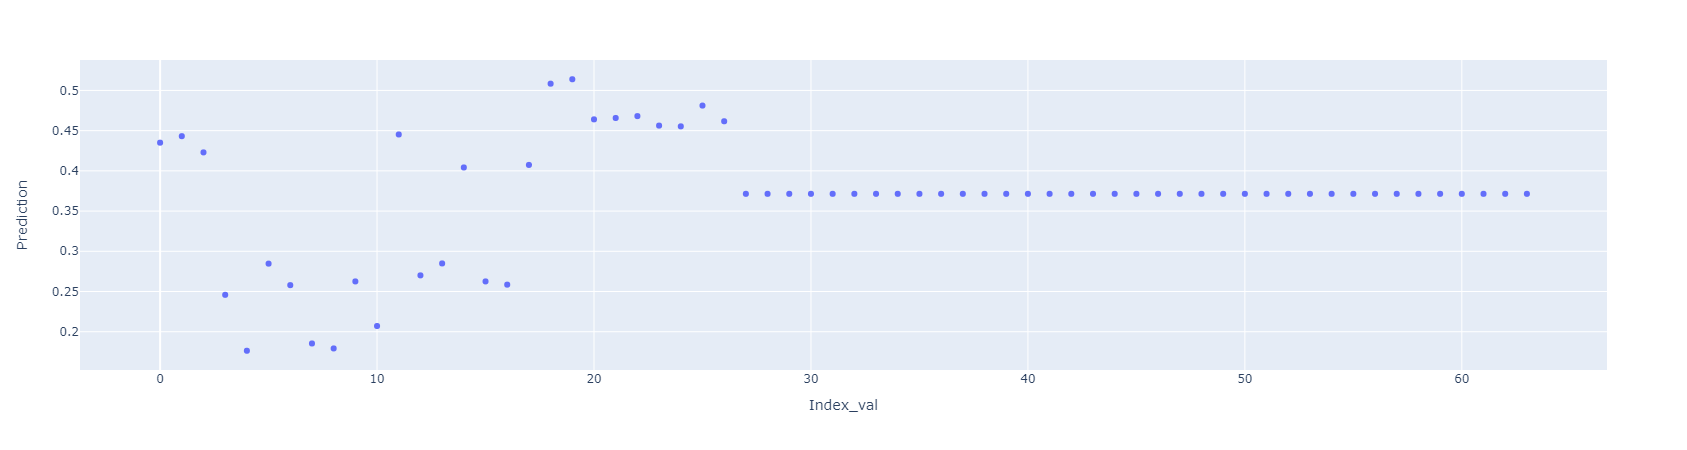

In [18]:
display(df_RNN)
df_RNN_line_chart=pd.DataFrame(columns=["Index_val","Prediction"])
for i,k in enumerate(df_RNN.prediction):
    #print(i,k[0][0])
    row1 = pd.Series([i,k[0][0]] ,index=df_RNN_line_chart.columns )
    df_RNN_line_chart.loc[len(df_RNN_line_chart.index)] = row1
    
display(df_RNN_line_chart)

df_RNN_line_chart_2=df_RNN.merge(df_RNN_line_chart,left_index=True,right_index=True)

display(df_RNN_line_chart_2)
    


import plotly.express as px
fig = px.scatter(df_RNN_line_chart_2, x="Index_val", y="Prediction",hover_data=['p_units','p_epoch','p_batch_size'])
fig.show()



In [19]:
#****---------------------------------------------------------------------------------------------------------------------------



In [20]:
#ANN SAMPLE

'''
import tensorflow as tf
from tensorflow.keras.layers import Dense



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)


ann=tf.keras.Sequential()
ann.add(tf.keras.layers.Dense(units=12,
                              activation="relu"))

ann.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
#ann.compile(loss='mean_squared_error', optimizer='adam' ,metrics=['mse'])

 Fitting the ANN to the Training set
ann.fit(X_train, y_train ,batch_size = 50, epochs = 100)
'''


'\nimport tensorflow as tf\nfrom tensorflow.keras.layers import Dense\n\n\n\nfrom sklearn.model_selection import train_test_split\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=False)\n\n\nann=tf.keras.Sequential()\nann.add(tf.keras.layers.Dense(units=12,\n                              activation="relu"))\n\nann.add(Dense(1, kernel_initializer=\'normal\'))\n\n# Compiling the model\n#ann.compile(loss=\'mean_squared_error\', optimizer=\'adam\' ,metrics=[\'mse\'])\n\n Fitting the ANN to the Training set\nann.fit(X_train, y_train ,batch_size = 50, epochs = 100)\n'